# RFM

In [511]:
df = data_clients.copy()

In [512]:
df.reset_index(inplace=True)

In [513]:
from datetime import datetime

In [514]:
df3 = df_original.copy()
df_original['OrderDate'] = pd.to_datetime(df_original['OrderDate'])
df3.rename(columns={'Phone_new': 'id'}, inplace=True)

In [515]:
# Объединение данных по id
df_merged = df.merge(
    df3[['id', 'OrderDate']],
    on='id',
    how='left'
)

In [516]:
print(df_merged[['id', 'OrderDate']].head())

                        id  OrderDate
0  55575456-52485253545172 2016-03-01
1  55575456-52485253545172 2016-03-01
2  55575456-52485253545172 2016-03-01
3  55575050-50535349495672 2016-03-01
4  55575050-50535349495672 2016-03-01


In [517]:
df_rfm = df.copy()

In [518]:
# Текущая дата
current_date = datetime.now()

# Расчет Recency (дней с последней транзакции)
df_rfm['Recency'] = (current_date - df_merged['OrderDate']).dt.days
df_rfm['Frequency'] = df['КОЛ-ВО ВЫКУПЛ.ТОВ.']
df_rfm['Monetary'] = df['СРЕДНИЙ ЧЕК']

In [519]:
df_rfm.head()

,index,id,Мелкая бытовая техника,Аксессуары,Цифровая Техника,Климат,Сделай сам,Детские товары,ТВ-Аудио,Крупная бытовая техника,Товары для дома,Спорт и активный отдых,Мебель,"Игры, софт и развлечения",Автотовары,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Южный ф.о.,Уральский ф.о.,Приволжский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Recency,Frequency,Monetary
0,0,55575456-52485253545172,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,2.0,3248.0,3380,2.0,3248.0
1,1,55575050-50535349495672,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,3.0,54497.0,3380,3.0,54497.0
2,2,55574954-49565455575577,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,140.0,1,2.0,1458.0,3380,2.0,1458.0
3,3,55574954-50515050575778,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2,2.0,2361.0,3380,4.0,2361.0
4,4,55575050-50485353485575,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,2.0,508.0,3380,2.0,508.0


In [520]:
# R - чем меньше, тем лучше => используем `qcut` с меткой 5 = самые "свежие"
df_rfm['R_score'] = pd.qcut(df_rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
# F и M — чем больше, тем лучше
df_rfm['F_score'] = pd.qcut(df_rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
df_rfm['M_score'] = pd.qcut(df_rfm['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)

In [521]:
# Объединённый RFM код
df_rfm['RFM_score'] = (
    df_rfm['R_score'].astype(str) +
    df_rfm['F_score'].astype(str) +
    df_rfm['M_score'].astype(str)
)

# Общая сумма баллов
df_rfm['RFM_total'] = df_rfm[['R_score', 'F_score', 'M_score']].sum(axis=1)

# Сегментация
def rfm_segment(x):
    if x >= 13:
        return 'Champions'
    elif x >= 10:
        return 'Loyal Customers'
    elif x >= 7:
        return 'Potential Loyalist'
    elif x >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

df_rfm['segment'] = df_rfm['RFM_total'].apply(rfm_segment)

In [522]:
df_rfm.head()

,index,id,Мелкая бытовая техника,Аксессуары,Цифровая Техника,Климат,Сделай сам,Детские товары,ТВ-Аудио,Крупная бытовая техника,Товары для дома,Спорт и активный отдых,Мебель,"Игры, софт и развлечения",Автотовары,Онлайн-Резерв.,Колл-центр,Сайт,Терминал,при получении,предоплата онлайн,Центральный ф.о.,Северо-Западный ф.о.,Сибирский ф.о.,Южный ф.о.,Уральский ф.о.,Приволжский ф.о.,Дальневосточный ф.о.,КОЛ-ВО ВЫКУПЛ.ТОВ.,СУММА СКИДКИ,КОЛ-ВО ЧЕКОВ,СРЕД.КОЛ.ТОВ.вЧеке,СРЕДНИЙ ЧЕК,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,RFM_total,segment
0,0,55575456-52485253545172,0.5,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,2.0,3248.0,3380,2.0,3248.0,1,1,2,112,4,Needs Attention
1,1,55575050-50535349495672,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,3.0,54497.0,3380,3.0,54497.0,1,4,5,145,10,Loyal Customers
2,2,55574954-49565455575577,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,140.0,1,2.0,1458.0,3380,2.0,1458.0,1,1,1,111,3,At Risk
3,3,55574954-50515050575778,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2,2.0,2361.0,3380,4.0,2361.0,1,5,1,151,7,Potential Loyalist
4,4,55575050-50485353485575,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1,2.0,508.0,3380,2.0,508.0,1,1,1,111,3,At Risk


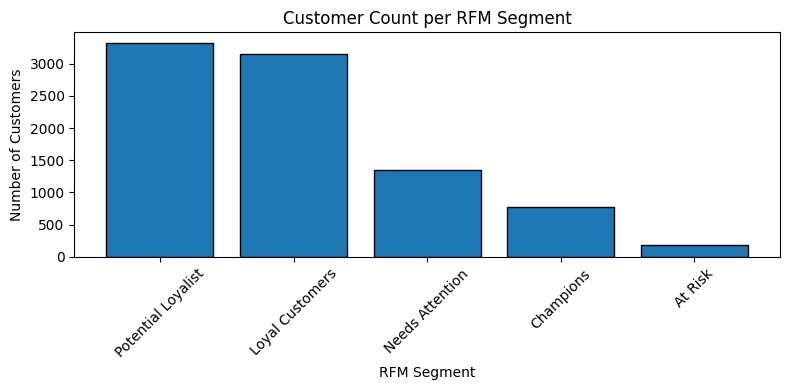

In [523]:
# Распределение по RFM-сегментам
counts = df_rfm['segment'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(8, 4))
plt.bar(counts.index, counts.values, edgecolor='black')
plt.xlabel('RFM Segment')
plt.ylabel('Number of Customers')
plt.title('Customer Count per RFM Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [524]:
#Category shares by RFM segments
cat_cols = [
    'Мелкая бытовая техника','Аксессуары','Цифровая Техника','Климат',
    'Сделай сам','Детские товары','ТВ-Аудио','Крупная бытовая техника',
    'Товары для дома','Спорт и активный отдых','Мебель',
    'Игры, софт и развлечения','Автотовары'
]

rfm_share_by_rfm = (
    df_rfm
    .groupby('segment')[cat_cols]
    .mean()
    .multiply(100)
    .round(1)
)
rfm_share_by_rfm.index.name = 'RFM Segment'
rfm_share_by_rfm

,Мелкая бытовая техника,Аксессуары,Цифровая Техника,Климат,Сделай сам,Детские товары,ТВ-Аудио,Крупная бытовая техника,Товары для дома,Спорт и активный отдых,Мебель,"Игры, софт и развлечения",Автотовары
RFM Segment,,,,,,,,,,,,,
At Risk,15.0,28.1,4.6,0.5,10.9,6.8,1.6,0.5,16.4,8.2,6.6,0.5,0.0
Champions,11.7,10.7,7.3,2.8,10.5,2.2,4.6,35.3,4.2,5.9,4.5,0.2,0.0
Loyal Customers,13.7,12.4,7.4,3.1,13.0,5.6,4.2,20.1,6.3,7.9,6.2,0.2,0.0
Needs Attention,18.0,20.0,9.9,2.1,11.5,6.2,3.4,4.3,8.2,8.9,7.2,0.3,0.1
Potential Loyalist,15.1,16.5,7.2,2.3,13.3,7.0,3.3,8.9,9.2,9.8,7.1,0.3,0.0


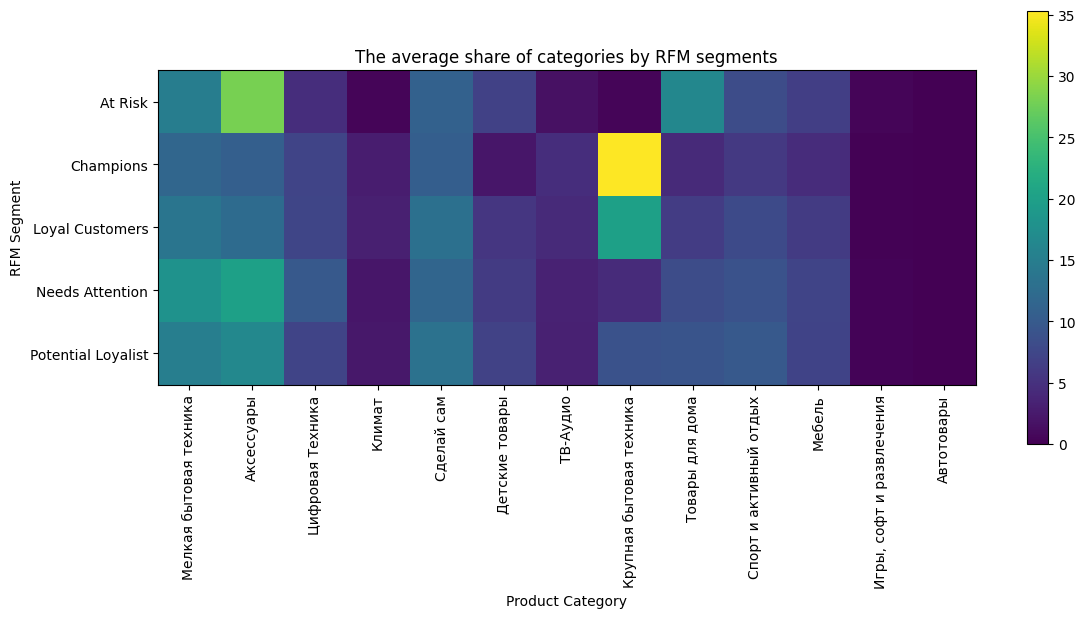

In [525]:
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(rfm_share_by_rfm.values)
ax.set_xticks(np.arange(len(cat_cols)))
ax.set_xticklabels(cat_cols, rotation=90)
ax.set_yticks(np.arange(len(rfm_share_by_rfm.index)))
ax.set_yticklabels(rfm_share_by_rfm.index)
plt.colorbar(im, ax=ax)
ax.set_title("The average share of categories by RFM segments")
plt.xlabel('Product Category')
plt.ylabel('RFM Segment')
plt.tight_layout()
plt.show()

# Hierarchical clustering for RFM segment "AT RISK"

In [526]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
df = df_rfm.copy()

In [527]:
df_at_risk_full = df[df['segment']=='At Risk'].copy()

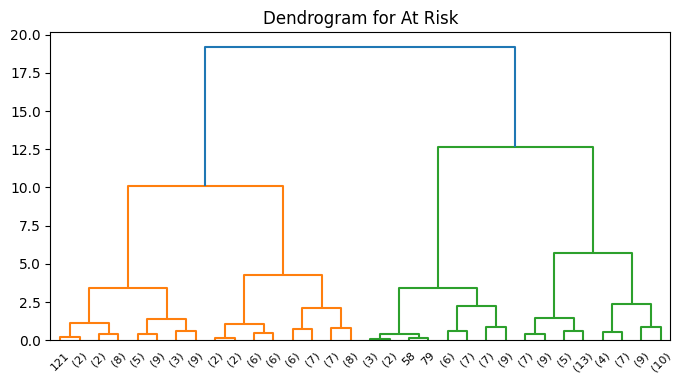

In [528]:
X = df_at_risk_full[['Recency','Frequency','Monetary']]
X_scaled = StandardScaler().fit_transform(X)

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=4)
plt.title("Dendrogram for At Risk")
plt.show()


In [529]:
df_at_risk_full['subcluster'] = fcluster(Z, 3, criterion='maxclust')

In [530]:
category_cols = [
    'Мелкая бытовая техника','Аксессуары','Цифровая Техника','Климат',
    'Сделай сам','Детские товары','ТВ-Аудио','Крупная бытовая техника',
    'Товары для дома','Спорт и активный отдых','Мебель',
    'Игры, софт и развлечения','Автотовары'
]

# 4) Группируем по subcluster и считаем средние доли
profile = (
    df_at_risk_full
    .groupby('subcluster')[category_cols]
    .mean()
    .round(3)
)

profile

,Мелкая бытовая техника,Аксессуары,Цифровая Техника,Климат,Сделай сам,Детские товары,ТВ-Аудио,Крупная бытовая техника,Товары для дома,Спорт и активный отдых,Мебель,"Игры, софт и развлечения",Автотовары
subcluster,,,,,,,,,,,,,
1,0.151,0.307,0.036,0.012,0.078,0.054,0.012,0.012,0.181,0.072,0.072,0.012,0.0
2,0.069,0.319,0.014,0.000,0.125,0.056,0.042,0.000,0.153,0.139,0.083,0.000,0.0
3,0.195,0.227,0.078,0.000,0.141,0.094,0.008,0.000,0.148,0.062,0.047,0.000,0.0


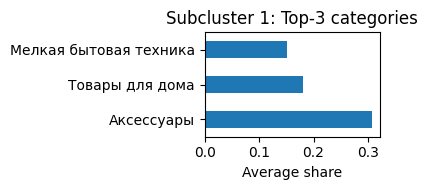

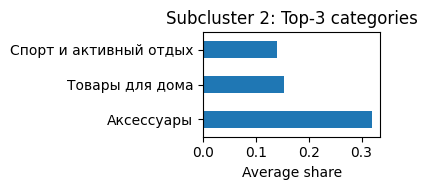

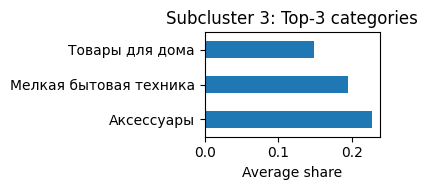

In [531]:
for sc in profile.index:
    top3 = profile.loc[sc].sort_values(ascending=False).head(3)
    plt.figure(figsize=(4,2))
    top3.plot.barh()
    plt.title(f"Subcluster {sc}: Top-3 categories")
    plt.xlabel("Average share")
    plt.tight_layout()
    plt.show()

| subcluster | Топ-3 категорий (доля)                                                                    | Интерпретация                                                                                                                                                                               |
| ---------: | ----------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
|      **1** | 1) Аксессуары — 0.307<br/>2) Мелкая быт. тех. — 0.151<br/>3) Товары для дома — 0.181      | Эта группа раньше активно докупала аксессуары (30 %) и товары для дома (18 %).
|      **2** | 1) Аксессуары — 0.319<br/>2) Спорт и актив. от дых — 0.139<br/>3) Товары для дома — 0.153 | У них точно так же лидирует «Аксессуары», но сильнее «Спорт и отдых» (14 %).
|      **3** | 1) Мелкая быт. тех. — 0.195<br/>2) Сделай сам — 0.141<br/>3) Аксессуары — 0.227           | Эта подгруппа любила ремонт и «сделай сам» (14 %), а также мелкую бытовую технику (20 %).                        |
